In [24]:
import torch
import numpy as np
import random
from IPython import display
from matplotlib import pyplot as plt
import torchvision
import torchvision.transforms as transforms
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"  #防止jupyter崩溃

In [25]:
#下载MNIST手写数据集
mnist_train = torchvision.datasets.MNIST(root='./Datasets/MNIST', train=True,
download=True, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.MNIST(root='./Datasets/MNIST', train=False,
download=True, transform=transforms.ToTensor())
#读取数据
batch_size = 32
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True,
num_workers=0)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False,
num_workers=0)

In [44]:
#初始化参数
# num_inputs,num_hiddens,num_outputs = 784,256,10
num_inputs,num_hiddens,num_outputs = 784,512,10
W1 = torch.tensor(np.random.normal(0, 0.01, (num_hiddens,num_inputs)), dtype=torch.float32)
b1 = torch.zeros(1, dtype=torch.float32)
W2 = torch.tensor(np.random.normal(0, 0.01, (num_outputs,num_hiddens)), dtype=torch.float32)
b2 = torch.zeros(1, dtype=torch.float32)
params =[W1,b1,W2,b2]
for param in params:
    param.requires_grad_(requires_grad=True)

In [27]:
def relu(x):
    x = torch.max(input=x,other=torch.tensor(0.0))
    return x

In [28]:
#使用三种不同的激活函数定义模型，分别使用sigmoid，relu，tanh
def net(X):
    X = X.view((-1,num_inputs))
    H=torch.sigmoid(torch.matmul(X,W1.t())+b1)
#     H = relu(torch.matmul(X,W1.t())+b1)
#     H=torch.tanh(torch.matmul(X,W1.t())+b1)
    return torch.matmul(H,W2.t())+b2

In [29]:
#定义交叉熵损失函数
loss = torch.nn.CrossEntropyLoss()

In [30]:
#定义随机梯度下降法
def SGD(paras,lr):
    for param in params:
        param.data -= lr * param.grad

In [31]:
#测试集loss
def evaluate_loss(data_iter,net):
    acc_sum,loss_sum,n = 0.0,0.0,0
    for X,y in data_iter:
        y_hat = net(X)
        acc_sum += (y_hat.argmax(dim=1)==y).sum().item()
        l = loss(y_hat,y) # l是有关小批量X和y的损失
        loss_sum += l.sum().item()*y.shape[0]
        n+=y.shape[0]
    return acc_sum/n,loss_sum/n

In [38]:
#定义模型训练函数
def train(net,train_iter,test_iter,loss,num_epochs,batch_size,params=None,lr=None,optimizer=None):
    train_ls = []
    test_ls = []
    for epoch in range(num_epochs): # 训练模型一共需要num_epochs个迭代周期
        train_l_sum, train_acc_num,n = 0.0,0.0,0
        # 在每一个迭代周期中，会使用训练数据集中所有样本一次
        for X, y in train_iter: # x和y分别是小批量样本的特征和标签
            y_hat = net(X)
            l = loss(y_hat, y).sum() # l是有关小批量X和y的损失
            #梯度清零
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            l.backward() # 小批量的损失对模型参数求梯度
            if optimizer is None:
                SGD(params,lr)
            else:
                optimizer.step()
            #计算每个epoch的loss
            train_l_sum += l.item()*y.shape[0]
            #计算训练样本的准确率
            train_acc_num += (y_hat.argmax(dim=1)==y).sum().item()
            #每一个epoch的所有样本数
            n+= y.shape[0]
        train_ls.append(train_l_sum/n)
        test_acc,test_l = evaluate_loss(test_iter,net)
        test_ls.append(test_l)
        print('epoch %d, train_loss %.6f,test_loss %f,train_acc %.6f,test_acc %.6f'%(epoch+1, train_ls[epoch],test_ls[epoch],train_acc_num/n,test_acc))
    return train_ls,test_ls

In [45]:
lr = 0.01
num_epochs = 5
train_loss,test_loss = train(net,train_iter,test_iter,loss,num_epochs,batch_size,params,lr)

epoch 1, train_loss 2.129098,test_loss 1.692820,train_acc 0.317567,test_acc 0.688400
epoch 2, train_loss 1.195982,test_loss 0.835157,train_acc 0.717133,test_acc 0.801300
epoch 3, train_loss 0.703254,test_loss 0.578887,train_acc 0.827083,test_acc 0.852900
epoch 4, train_loss 0.540144,test_loss 0.475490,train_acc 0.860517,test_acc 0.875100
epoch 5, train_loss 0.464637,test_loss 0.424683,train_acc 0.876267,test_acc 0.885500


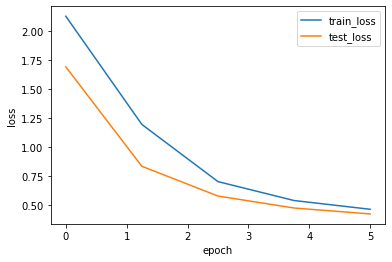

In [46]:
x = np.linspace(0,len(train_loss),len(train_loss))
plt.plot(x,train_loss,label="train_loss",linewidth=1.5)
plt.plot(x,test_loss,label="test_loss",linewidth=1.5)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()